# Collecting data Report
Ran Huo r0817066

## Introduction
Using a data set from a camera reviewing website, models between reviewing words and the overall score of the cameras are built.


## Get Data
DXOMARK IMAGE LABS is a private French engineering company which specialize in the measurement of camera, audio, display and battery quality of all types of consumer electronics. 
Here I collect the data of the cameras from their website [www.dxomark.com/Cameras](https://www.dxomark.com/Cameras/)

In [195]:
import numpy as np
import pandas as pd
import requests
import json

In [ ]:
from requests_html import HTMLSession

session = HTMLSession()
url = 'https://www.dxomark.com/Cameras/'
r = session.get(url)
r.status_code

In [ ]:
print(r.html.text)

Sensors Database - DxOMark
(function(html){html.className = html.className.replace(/\bno-js\b/,'js')})(document.documentElement);
/* <![CDATA[ */ var cnArgs = {"ajaxUrl":"https:\/\/www.dxomark.com\/wp-admin\/admin-ajax.php","nonce":"656d22d810","hideEffect":"fade","position":"bottom","onScroll":"0","onScrollOffset":"100","onClick":"0","cookieName":"cookie_notice_accepted","cookieTime":"2592000","cookieTimeRejected":"2592000","cookiePath":"\/","cookieDomain":"","redirection":"0","cache":"0","refuse":"1","revokeCookies":"0","revokeCookiesOpt":"automatic","secure":"1","coronabarActive":"0"}; /* ]]> */ /* <![CDATA[ */ var cmtt_data = {"tooltip":{"clickable":0,"top":3,"left":23,"endalpha":95,"borderStyle":"none","borderWidth":"0px","borderColor":"#000","fontSize":"13px","padding":"2px 12px 3px 7px","borderRadius":"6px"},"ajaxurl":"https:\/\/www.dxomark.com\/wp-admin\/admin-ajax.php"}; /* ]]> */ /* <![CDATA[ */ var wpml_xdomain_data = {"css_selector":"wpml-ls-item","ajax_url":"https:\/\/www.

The page of cameras is generated by JS, which mean we can get the list of cameras directly from the html documents. Lukily, with the help of developer tools, I had found the json document used by the JS code. That make the collecting much easier now.

In [ ]:
r = requests.get('https://www.dxomark.com/daksensor/ajax/jsontested?locale=en')
search_json = r.json()
search_json.keys()
search_json['year']
data=search_json['data']
data[1]

{'autofocus': 'no',
 'brand': 'Canon',
 'chapo': None,
 'flash': 'no',
 'id': 437,
 'image': 'https://cdn.dxomark.com/dakdata/xml/EOS_10D/vignette3.png',
 'launchDate': 'Feb. 2003',
 'launchDateGraph': '2003-02-27',
 'link': '/Cameras/Canon/EOS-10D',
 'linkReview': None,
 'maximum_iso': 0,
 'name': 'Canon EOS 10D',
 'pixelDepth': 6.3,
 'price': 347,
 'rankColor': 21.1,
 'rankColor_ranking': 308,
 'rankDxo': 57,
 'rankDxo_ranking': 286,
 'rankDyn': 10.9,
 'rankDyn_ranking': 317,
 'rankLln': 571,
 'rankLln_ranking': 248,
 'raw_format': 'no',
 'resolutionvideo': 0,
 'sensor': 'sensor_apsc',
 'sensorraw': 6.52,
 'status': 'TESTED',
 'type': 'semiprodslr',
 'video': 'no',
 'waterproof': 'no',
 'year': '2003'}

In [ ]:
df = pd.DataFrame(search_json['data'])
df.sort_values(by="id" , inplace=True, ascending=True) 
df.shape[0]


386

In [ ]:
df.sample(5)

,id,price,year,brand,rankDxo,rankColor,rankDyn,rankLln,rankDxo_ranking,rankColor_ranking,rankDyn_ranking,rankLln_ranking,name,pixelDepth,sensor,type,status,launchDate,launchDateGraph,sensorraw,link,chapo,linkReview,maximum_iso,raw_format,autofocus,resolutionvideo,flash,video,waterproof,image
377,1352,6500,2020,Canon,91,24.2,14.5,3248,34,69,16,20,Canon EOS-1D X Mark III,20.1,sensor_fullframe,professional,TESTED,Jan. 2020,2020-01-07,20.17,/Cameras/Canon/EOS-1D-X-Mark-III,,,0,no,no,0,no,no,no,https://cdn.dxomark.com/dakdata/xml/_EOS-1D_X_...
119,675,750,2010,Sony,73,23.0,12.4,816,155,151,160,169,Sony SLT Alpha 55,16.2,sensor_apsc,"entryleveldslr, semiprodslr",TESTED,Aug. 2010,2010-08-24,16.20,/Cameras/Sony/SLT-Alpha-55,None,None,0,no,no,0,no,no,no,https://cdn.dxomark.com/dakdata/xml/SLT_Alpha_...
264,944,2850,2013,Leica,78,23.4,12.7,1320,117,130,117,84,Leica X Vario,16.2,sensor_apsc,highendcompact,TESTED,Jun. 2013,2013-06-11,16.19,/Cameras/Leica/X-Vario,Introduction After the success of the APS-...,https://www.dxomark.com/leica-x-vario-sensor-r...,0,no,no,0,no,no,no,https://cdn.dxomark.com/dakdata/xml/X_Vario/vi...
68,631,1100,2009,Olympus,56,21.5,10.4,505,296,277,353,292,Olympus PEN EP2,12.3,sensor_micro43,hybrid,TESTED,Nov. 2009,2009-11-05,12.64,/Cameras/Olympus/PEN-EP2,None,None,0,no,no,0,no,no,no,https://cdn.dxomark.com/dakdata/xml/PEN_EP2/vi...
17,272,1300,2008,Canon,63,21.8,11.4,696,253,265,255,210,Canon EOS 50D,15.1,sensor_apsc,semiprodslr,TESTED,Aug. 2008,2008-08-26,15.15,/Cameras/Canon/EOS-50D,None,None,0,no,no,0,no,no,no,https://cdn.dxomark.com/dakdata/xml/EOS_50D/vi...


The data set contain 385 cameras, while some of them only have tested score instead of reviews. Thus they will be deleted from the data set, remaining only these with reviewss.

In [ ]:
df=df.dropna(axis=0, subset=['linkReview', 'chapo'])

In [ ]:
df=df.reset_index()

Using the column 'link' in the data set, the links of each camera are obtained.

In [ ]:
url = 'https://www.dxomark.com'
links=df['link']
links=url+links
camname=df['name']

In [ ]:
links

0            https://www.dxomark.com/Cameras/Pentax/K10D
1      https://www.dxomark.com/Cameras/Panasonic/Lumi...
2      https://www.dxomark.com/Cameras/Phase-One/P45-...
3      https://www.dxomark.com/Cameras/Hasselblad/H3D...
4      https://www.dxomark.com/Cameras/Olympus/SP-565-UZ
                             ...                        
241          https://www.dxomark.com/Cameras/Sony/A7SIII
242          https://www.dxomark.com/Cameras/Leica/SL2-S
243           https://www.dxomark.com/Cameras/Nikon/Z7II
244    https://www.dxomark.com/Cameras/Panasonic/Lumi...
245           https://www.dxomark.com/Cameras/Nikon/Z6II
Name: link, Length: 246, dtype: object

In the html document, the class of review words is 'main-post'. Here a new column 'reviews' is developed to storage the reviews collected from each page.

In [ ]:
def scrape_review(url):
   campage = session.get(url)
   review=campage.html.find('.main-post')[0].text
   return review

In [ ]:
df['reviews']=None

for i in range(df.shape[0]):
    url = links[i]
    text = scrape_review(url)
    df.reviews[i]=text

Then we get the csv document.

In [ ]:
df.to_csv("camdata.csv")

##Analysis

In [2]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import numpy as np

In [3]:
df = pd.read_csv("camdata.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 233 non-null    int64  
 1   price              233 non-null    int64  
 2   year               233 non-null    int64  
 3   brand              233 non-null    object 
 4   rankDxo            233 non-null    int64  
 5   rankColor          233 non-null    float64
 6   rankDyn            233 non-null    float64
 7   rankLln            233 non-null    int64  
 8   rankDxo_ranking    233 non-null    int64  
 9   rankColor_ranking  233 non-null    int64  
 10  rankDyn_ranking    233 non-null    int64  
 11  rankLln_ranking    233 non-null    int64  
 12  name               233 non-null    object 
 13  pixelDepth         233 non-null    float64
 14  sensor             229 non-null    object 
 15  type               233 non-null    object 
 16  status             233 non

In [5]:
np.max(df['rankDxo'], axis=0)

102

In [6]:
np.min(df['rankDxo'], axis=0)

29

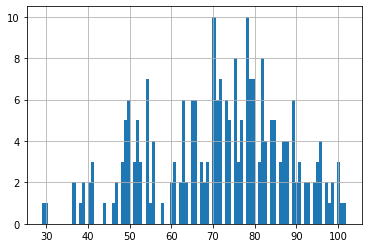

In [8]:
h = df['rankDxo'].hist(bins=100)

The variable rankDxo represent the overall tested score of a camera, having a range from 29 to 102. To make the classification more intuitive, I decided to divided the cameras in two group('high' and 'low')s by their rankDxo. A new variable rating is created.

In [70]:
df['rating']=None

for i in range(df.shape[0]):
    if df.rankDxo[i] <= 65 :
     df.rating[i]='low'
    if  df.rankDxo[i] >65 :
     df.rating[i]='high'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [71]:
df['rating'].value_counts()

high    158
low      75
Name: rating, dtype: int64

###Sentimental Analysis

In [57]:
%pip install vaderSentiment

In [58]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [59]:
def sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    return score

In [60]:
df['sentiment'] = df['reviews'].apply(sentiment)

In [271]:
df.groupby('rating')[['sentiment']].describe()

sentiment                      ...                          
           count      mean       std  ...     50%       75%     max
rating                                ...                          
high       158.0  0.625332  0.361783  ...  0.7430  0.886775  0.9910
low         75.0  0.474973  0.495046  ...  0.6597  0.858700  0.9688

[2 rows x 8 columns]

With the SentimentIntensityAnalyzer, the sentiment scores of the two rating parts are attained.

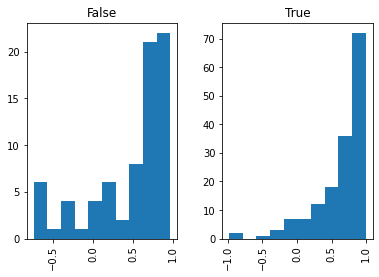

In [62]:
hist= df['sentiment'].hist(by=df['rating'])

From the above histgram plot we can see the result of sentimental analysis is not ideal. Maybe it is because when authors writing a review of a camera, they will do their best to make the words objective.

### Text classification

#### Logestic model

In [176]:
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

I built two logestic models, one using words as predictor, another using topics.

##### Topic
This part is the preparation for the topic model. Using LDA model the words have been divided into 10 topics.

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [91]:
vect = CountVectorizer(min_df=40, 
                       stop_words = nltk_stops,
                       max_df=0.6,
                      max_features=1000)

In [92]:
vect.fit(df['reviews'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.6, max_features=1000, min_df=40,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [93]:
tf = vect.transform(df['reviews'])

In [94]:
lda_model = LatentDirichletAllocation(n_components   = 10,
                                      max_iter       = 100,
                                      evaluate_every = 5,
                                      verbose = 2,
                                      n_jobs= 2,
                                     )

In [95]:
lda_model.fit(tf)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100, perplexity: 40.6018


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


iteration: 10 of max_iter: 100, perplexity: 38.9790
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]

iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100, perplexity: 38.1889
iteration: 16 of max_iter: 100


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 38.0036


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]

iteration: 25 of max_iter: 100, perplexity: 37.8642
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]

iteration: 30 of max_iter: 100, perplexity: 37.7491
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of max_iter: 100
iteration: 34 of max_iter: 100
iteration: 35 of max_iter: 100, perplexity: 37.7410


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=5, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=100,
                          mean_change_tol=0.001, n_components=10, n_jobs=2,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=2)

In [98]:
from pdtext.tm import topic_words

In [99]:
topic_df = topic_words(lda_model, vect)
topic_df.head(10)

,1,2,3,4,5,6,7,8,9,10
Topic 1,canon,new,introduction,aps,camera,range,12,iso,image,first
Topic 2,mpix,model,new,introduction,features,inch,cmos,models,body,24
Topic 3,high,camera,aps,new,first,one,resolution,features,mpix,24
Topic 4,af,system,features,also,body,camera,model,12,cmos,type
Topic 5,sony,new,aps,camera,cameras,range,also,body,system,24
Topic 6,iso,dxomark,low,light,range,cameras,performance,aps,one,high
Topic 7,nikon,new,range,low,first,model,camera,image,24,features
Topic 8,full,frame,resolution,24,cmos,camera,features,high,first,12
Topic 9,quality,image,compact,dxomark,introduction,camera,sensitivity,cameras,one,new
Topic 10,compact,lens,camera,high,type,12,introduction,range,cmos,sensitivity


In [100]:
topic_predictions = lda_model.transform(tf)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.1s finished


In [101]:
topic_predictions_df = pd.DataFrame(topic_predictions)

In [102]:
topic_predictions_df.groupby(df['rating']).mean()

,0,1,2,3,4,5,6,7,8,9
rating,,,,,,,,,,
high,0.067427,0.185402,0.133850,0.104177,0.109584,0.114250,0.067357,0.109018,0.047608,0.061327
low,0.113541,0.213607,0.069523,0.044507,0.028501,0.145839,0.104302,0.035153,0.073637,0.171390


Here we get the pecentage of the 10 topics in the two rating groups.

##### Fit the logestic model(words)

In [23]:
from nltk.corpus import stopwords
nltk_stops = stopwords.words('english')

In [136]:
lr_classifier = LogisticRegression(max_iter=1000)
vectorizer = CountVectorizer(lowercase   = True,
                             ngram_range = (1,1),
                             min_df=40,
                             stop_words = nltk_stops,
                             max_features=1000)

In [232]:
vectorizer.fit(train['reviews'])
train_tf = vectorizer.transform(train['reviews'])
lr_classifier.fit(train_tf, train['rating'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [233]:
train_tf = vectorizer.transform(train['reviews'])
train_pred = lr_classifier.predict(train_tf)

In [234]:
test_tf = vectorizer.transform(test['reviews'])
test_pred = lr_classifier.predict(test_tf)

In [139]:
pipeline = Pipeline([
                     ('vectorizer' , CountVectorizer(stop_words=nltk_stops)),
                     ('classifier' , LogisticRegression(max_iter=1000))
                    ])

parameters = {'vectorizer__max_df' : [.5, .6, .7 ],
              'vectorizer__min_df' : [20, .005, .01, .02],         
               }

Here we build three models with different parameters.

In [126]:
grid_search = GridSearchCV(pipeline,
                           parameters,
                           n_jobs = -1,
                           cv = 3,
                           verbose = 2)

In [127]:
grid_search.fit(train['reviews'],
                train['rating'])

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    2.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                      

In [128]:
best_pipe = grid_search.best_estimator_
test_pred = best_pipe.predict(test['reviews'])

In [129]:
print(classification_report(test['rating'],
                            test_pred))

              precision    recall  f1-score   support

        high       0.79      0.93      0.85        28
         low       0.86      0.63      0.73        19

    accuracy                           0.81        47
   macro avg       0.82      0.78      0.79        47
weighted avg       0.82      0.81      0.80        47



The accuracy of the best one among these three models is 0.82, which is a satisfactory value.

##### Fit the logestic model(topic)
Using vectorized topics as predictor, we built a another logestic model.

In [130]:
train_topics = lda_model.transform(vect.transform(train['reviews']))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


In [131]:
lr_classifier.fit(train_topics, train['rating'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [132]:
test_topics = lda_model.transform(vect.transform(test['reviews']))
test_prediction = lr_classifier.predict(test_topics)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.0s finished


In [133]:
print(classification_report(test['rating'],
                            test_prediction))

              precision    recall  f1-score   support

        high       0.61      1.00      0.76        28
         low       1.00      0.05      0.10        19

    accuracy                           0.62        47
   macro avg       0.80      0.53      0.43        47
weighted avg       0.77      0.62      0.49        47



The accuracy is a bit lower than that of the former model.

##### Conclusion

In [140]:
coeficients = pd.Series(lr_classifier.coef_[0],
                        index = vectorizer.get_feature_names())
coeficients.sort_values(ascending=True)[:25]

full           -1.115639
aps            -1.002620
24             -0.960484
features       -0.891961
sony           -0.766143
new            -0.518112
review         -0.511369
frame          -0.475869
low            -0.415126
resolution     -0.369039
cameras        -0.286699
camera         -0.172706
range          -0.167869
mpix           -0.068598
model           0.010667
sensor          0.051000
iso             0.090233
introduction    0.171158
cmos            0.235407
nikon           0.311234
image           0.332051
also            0.359265
canon           0.458038
high            0.492898
lens            0.677976
dtype: float64

In [141]:
coeficients.sort_values(ascending=False)[:25]

compact         0.826710
lens            0.677976
high            0.492898
canon           0.458038
also            0.359265
image           0.332051
nikon           0.311234
cmos            0.235407
introduction    0.171158
iso             0.090233
sensor          0.051000
model           0.010667
mpix           -0.068598
range          -0.167869
camera         -0.172706
cameras        -0.286699
resolution     -0.369039
low            -0.415126
frame          -0.475869
review         -0.511369
new            -0.518112
sony           -0.766143
features       -0.891961
24             -0.960484
aps            -1.002620
dtype: float64

Here we get the coefficients of the best logestic model(using words). The word with highest coefficient is 'impact', which indicates that the weight of a camera can significant effect the comments.

 Another interesting thing is that 'sony' has a really significantly negative coefficient, while 'canon' and 'nikon' have postive coefficients. All these three words are the bands of cameras.

 Then a heatmap about the training data is drew to have a overview of the model.

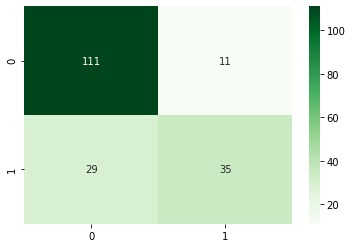

In [182]:
cm1 = confusion_matrix(train['rating'], train_pred)
sns.heatmap(cm1, annot=True, cmap="Greens", fmt='g')

#### K-NN Model

In [149]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

Several KNN models are built to select a better one.

In [166]:
parameters2 = {'n_neighbors' : [1,3,5],
              'weights'      : ['distance', 'uniform']}
grid2 = GridSearchCV(KNeighborsClassifier(), 
                    parameters2, 
                    cv = 3,
                    n_jobs = -1,
                   verbose = 2)

In [157]:
tf_vector=TfidfVectorizer()

In [158]:
tf_vector.fit(train['reviews'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [235]:
train_tfidf = tf_vector.transform(train['reviews'])

In [236]:
grid2.fit(train_tfidf,train['rating'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    1.1s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5],
                         'weights': ['distance', 'uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [237]:
knn_prediction = grid2.predict(train_tfidf)

In [171]:
grid2.best_score_

0.8172043010752689

In [173]:
grid2.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')

Here we get the parameters of the better KNN model.

In [174]:
print(accuracy_score(test['rating'], 
                     grid2.best_estimator_.predict(tf_vector.transform(test['reviews']))))

0.851063829787234


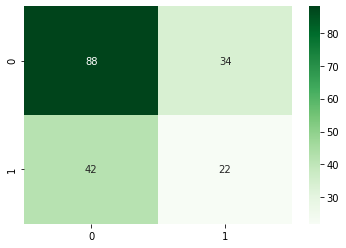

In [177]:
cm2 = confusion_matrix(train['rating'], knn_prediction)
sns.heatmap(cm2, annot=True, cmap="Greens", fmt='g')

Here is the accuracy and heatmap of the KNN model. It's obvious that logestic model preforms better.

#### Machine Learning

##### Random Forest

In [281]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [184]:
rf_clf = RandomForestClassifier(max_depth =5, 
                                n_estimators=100)

In [239]:
rf_clf.fit(train_tf, train['rating'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [240]:
print("train score: %.3f" % rf_clf.score(train_tf, train['rating']))
print("test score: %.3f" % rf_clf.score(test_tf, test['rating']))

train score: 0.909
test score: 0.830


Both the train score and test score are satisfactory.

In [241]:
test_treepred = rf_clf.predict(test_tf)

In [242]:
print(classification_report(test['rating'],
                            test_treepred))


              precision    recall  f1-score   support

        high       0.82      1.00      0.90        36
         low       1.00      0.27      0.43        11

    accuracy                           0.83        47
   macro avg       0.91      0.64      0.66        47
weighted avg       0.86      0.83      0.79        47



##### Boosting

In [243]:
ab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                            n_estimators=50)

Here three boosting models are built to get a best one.

In [244]:
parametersB = {'base_estimator__max_depth':[30, 50 ],
             'n_estimators' : [20, 40],
             'learning_rate':[0.01,0.1] }

ab_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

g_clf = GridSearchCV(ab_clf, parametersB, cv=3, n_jobs=-1, verbose=2)

In [246]:
train_tf = best_pipe['vectorizer'].transform(train['reviews'])

In [247]:
g_clf.fit(train_tf,
                train['rating'])

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [248]:
g_clf.best_params_

{'base_estimator__max_depth': 30, 'learning_rate': 0.01, 'n_estimators': 20}

We find the best one among the three boosting models.

In [249]:
best_ada= g_clf.best_estimator_
test_tf = best_pipe['vectorizer'].transform(test['reviews'])
ada_pred = g_clf.predict(test_tf)

In [250]:
print(classification_report(test['rating'],
                            ada_pred))

              precision    recall  f1-score   support

        high       0.83      0.69      0.76        36
         low       0.35      0.55      0.43        11

    accuracy                           0.66        47
   macro avg       0.59      0.62      0.59        47
weighted avg       0.72      0.66      0.68        47



The accuracy is lower than random forest models.

## Conclusion
Several models are built to predict the score of a carema using the reviews as predictor.
The sentimental analysis is not working, which may caused by the objective attitude of the authors.
Among the rest models, random forests model is the best one, which has a test score of 0.83.